In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import argparse
import os
import tqdm
import scipy.ndimage as nd
from torchvision import transforms

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 15, 10

In [112]:
import os
!wget https://i.pinimg.com/originals/2e/8c/84/2e8c84564c24422e32f755b79b7d5907.jpg

--2020-08-29 07:36:15--  https://i.pinimg.com/originals/2e/8c/84/2e8c84564c24422e32f755b79b7d5907.jpg
Resolving i.pinimg.com (i.pinimg.com)... 23.54.200.222, 2600:1402:3800:290::1931, 2600:1402:3800:2a4::1931, ...
Connecting to i.pinimg.com (i.pinimg.com)|23.54.200.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72445 (71K) [image/jpeg]
Saving to: ‘2e8c84564c24422e32f755b79b7d5907.jpg.1’

2e8c84564c24422e32f 100%[===================>]  70.75K  --.-KB/s    in 0.04s   

2020-08-29 07:36:15 (1.91 MB/s) - ‘2e8c84564c24422e32f755b79b7d5907.jpg.1’ saved [72445/72445]



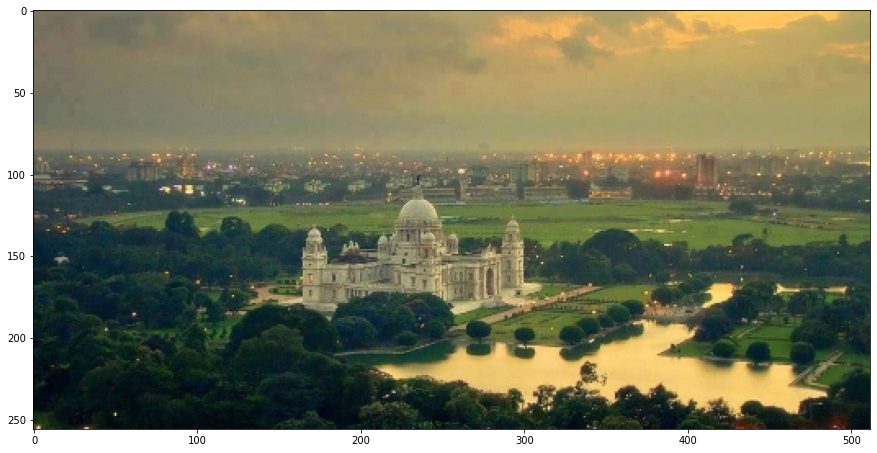

In [113]:
import cv2 

image = cv2.imread("2e8c84564c24422e32f755b79b7d5907.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (512,256))

plt.imshow(image)
plt.show()

In [114]:
model = models.vgg19(pretrained=True)
layers = list(model.features.children())
model.eval()
if torch.cuda.is_available:
    model = model.cuda()
# print(model)

In [115]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
preprocess = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

In [116]:

class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()
  
#Function to make gradients calculations from the output channels of the target layer  
def get_gradients(net_in, net, layer):     
  net_in.requires_grad = True
  net.zero_grad()
  hook = Hook(layer)
  net_out = net(net_in)
  loss = hook.output[0].norm()
  loss.backward()
  return net_in.grad.data.squeeze()

In [117]:
def dream(image_np, model, layer, iterations, lr):

    image_tensor = preprocess(image_np).unsqueeze(0).cuda()

    for i in range(iterations):
        gradients = get_gradients(image_tensor, model, layer)
        image_tensor.data = image_tensor.data + lr * gradients.data

    img_out = image_tensor.detach().cpu()[0]
    img_out_np = np.moveaxis(img_out.numpy(), 0,2)

    return img_out_np

In [118]:
for i in range(len(layers)):
    print(i, layers[i])

0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 ReLU(inplace=True)
2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 ReLU(inplace=True)
4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
5 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6 ReLU(inplace=True)
7 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 ReLU(inplace=True)
9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
10 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 ReLU(inplace=True)
12 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
13 ReLU(inplace=True)
14 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15 ReLU(inplace=True)
16 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
17 ReLU(inplace=True)
18 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
19 Conv2d(256, 512, kernel_size=(3, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


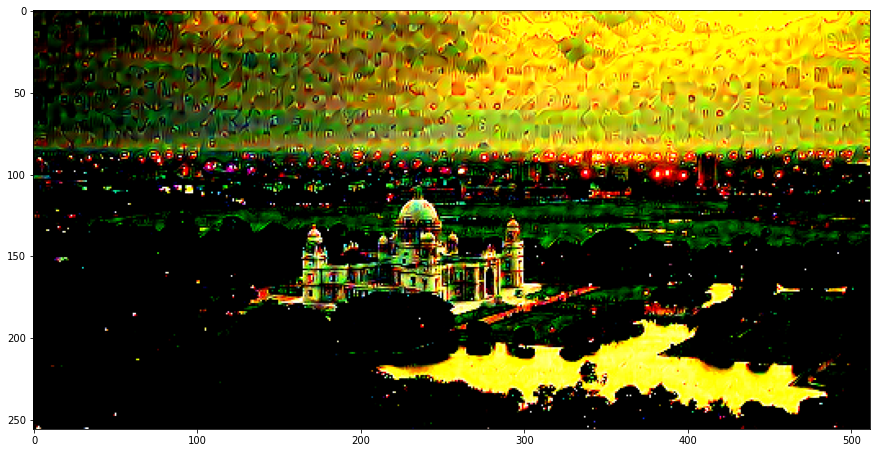

In [120]:
foo = dream(image, model, layers[7], iterations = 30, lr = 0.008)
plt.imshow(foo)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


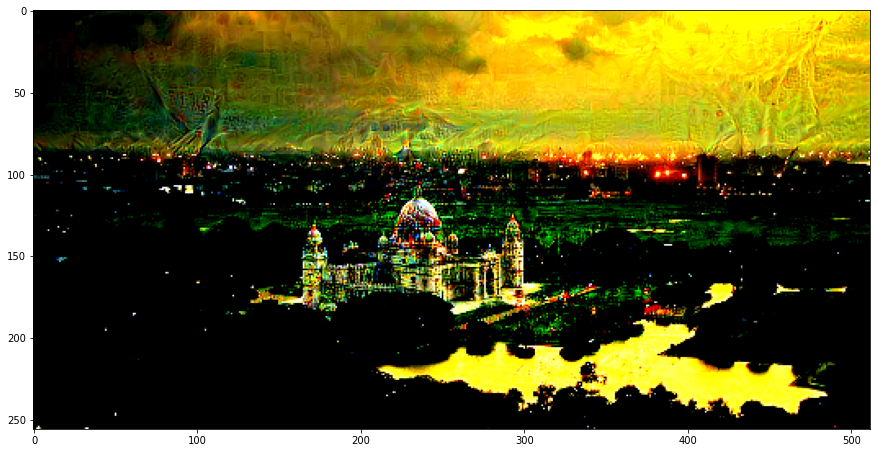

In [119]:
foo = dream(image, model, layers[34], iterations = 20, lr = 0.008)
plt.imshow(foo)